# Setup

In [8]:
from torch.optim import lr_scheduler
import math

In [2]:
%run setup.ipynb 

In [7]:
# Dataloaders of batch size 16, NB: set num_workers to 4 for stinna's pc and batch size 16 specifically
dataloader_train_16 = torch.utils.data.DataLoader(dataset_train, batch_size=16, num_workers=4, shuffle=True)
dataloader_validation_16 = torch.utils.data.DataLoader(dataset_val, batch_size=16, num_workers=4, shuffle=True)
dataloader_test_16 = torch.utils.data.DataLoader(dataset_test, batch_size=16, num_workers=4, shuffle=False)
dataloader_feeder_16 = torch.utils.data.DataLoader(dataset_feeder, batch_size=16, num_workers=4, shuffle=False)

Make a train function that takes a lr scheduler as input as well

In [3]:
def train_model_scheduled(model, optimizer,scheduler, num_epoch=5, train = dataloader_train, validation= dataloader_validation):
    acc_train = []
    loss_train = []
    acc_validation = []
    loss_validation = []
    lr_rate = []
    best_acc = 0.0
    best_loss = 1.0
    best_epoch = 0
    best_model_weight = copy.deepcopy(model.state_dict())

    since = time.time()
    for epoch in range(num_epoch):
        epoch_since = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epoch))
        print("-"*10)
        print('Learning rate: {:n}'.format(scheduler.get_last_lr()[0]))
        lr_rate.append(scheduler.get_last_lr()[0])
        #training phase
        
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train:
            inputs = inputs.to(device)
            labels = labels.to(device)

            #zero the parameter gradients 
            optimizer.zero_grad()

            #forward
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                criterion = torch.nn.CrossEntropyLoss()
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                scheduler.step() # <----------------
                
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss_train = running_loss / dataset_size_train
        epoch_acc_train = running_corrects.double() / dataset_size_train
        acc_train.append(epoch_acc_train.item())
        loss_train.append(epoch_loss_train)
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))

        #validation phase
        model.eval()
        running_loss_val = 0.0
        running_corrects_val = 0
        for inputs, labels in validation:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                criterion = torch.nn.CrossEntropyLoss()
                loss = criterion(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)
            running_corrects_val += torch.sum(preds == labels.data)
        epoch_loss_val = running_loss_val / dataset_size_val
        epoch_acc_val = running_corrects_val.double() / dataset_size_val
        acc_validation.append(epoch_acc_val.item())
        loss_validation.append(epoch_loss_val)
        print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_val, epoch_acc_val))
        
        if(epoch_acc_val > best_acc):
            best_acc = epoch_acc_val
            best_loss = epoch_loss_val #not ness the best loss overall but the loss of the best model
            best_epoch = epoch+1
            best_model_weight = copy.deepcopy(model.state_dict())
        
        time_epoch_val = time.time() - epoch_since           
        print('Epoch time {:.0f}m {:.0f}s'.format(time_epoch_val // 60, time_epoch_val % 60))
        print("-"*10)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best model had accuracy {:.4f}, loss {:.4f} at epoch {}".format(best_acc, best_loss, best_epoch))
    print("Validation accuracies:")
    print(acc_validation)
    print("Training accuracies:")
    print(acc_train)
    print(scheduler.state_dict())
    data = {"train_loss": loss_train, "val_loss": loss_validation, "train_acc": acc_train, "val_acc": acc_validation, "lr_rates": lr_rate}
    model.load_state_dict(best_model_weight)
    return model, data

In [4]:
def plot_learning_rate(lr_rates):
    num_epochs = len(lr_rates)
    # fig = plt.figure(figsize=(7,5))
    plt.plot(np.arange(1,num_epochs+1), lr_rates,'-')
    plt.xlabel('Steps')
    plt.legend(["lr"])
    plt.ylabel('Learning rate')
    plt.title('Learning rate/Steps')
    plt.show()
    # return fig

In [5]:
def plot_learning_loss(lr_rates, loss, log_scale=False):
    # plt.figure(figsize=(7,5))
    plt.plot(lr_rates, loss,'-')
    plt.xlabel("Learning rate " + ("(log)" if log_scale else ""))
    if log_scale:
        plt.xscale("log")
    for a,b in zip(lr_rates[::4], loss[::4]):
        if a > 3e-3:
            plt.text(a,b, str(a))
    plt.ylabel("Loss")
    plt.title("loss/learning rate")
    plt.show()

## "Linear" Learning Rate

In [ ]:
# training_in_here = dataloader_train
# validation_in_here = dataloader_validation
# num_epochs = 24

Define model, optimizer and learning rate scheduler

In [ ]:
# model = load_and_prep_resnet50()
# optimizer = get_optimizer(model) # <-- this has lr=0.001 dont know if we should start somewhere else?
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9) # <- then decay this instead

# # Decays the learning rate of each parameter group by linearly changing small multiplicative factor 
# # default starting point is 1./3
# # default end point is 0.1
# linear_scheduler = lr_scheduler.LinearLR(optimizer=optimizer, total_iters=num_epochs)

In [ ]:
# freezeTrained_model_linear, freezeData_linear = train_model_scheduled(model=model, optimizer=optimizer, scheduler=linear_scheduler, num_epoch=num_epochs, train=training_in_here, validation=validation_in_here )

In [ ]:
# unfreeze_layers(freezeTrained_model_linear)
# man skal vel også reload learning rate scheduler ?? Synes ikke de gør til tø tho...
# model_linear, model_linear_data = train_model_scheduled(model=freezeTrained_model_linear, optimizer=optimizer, scheduler=linear_scheduler, num_epoch=num_epochs, train=training_in_here, validation=validation_in_here)

In [ ]:
# plot_accuracies(model_linear_data["train_acc"], model_linear_data["val_acc"], ["Train", "Val"])
# Validation accuracies:
# [0.20192307692307693, 0.21153846153846154, 0.28846153846153844, 0.25961538461538464, 0.16346153846153846, 0.3557692307692308, 0.25961538461538464, 0.36538461538461536, 0.36538461538461536, 0.3173076923076923, 0.40384615384615385, 0.4519230769230769, 0.5192307692307693, 0.49038461538461536, 0.5865384615384616, 0.6346153846153846, 0.5865384615384616, 0.7596153846153846, 0.7211538461538461, 0.7307692307692307, 0.7115384615384616, 0.7211538461538461, 0.7019230769230769, 0.75]
# Training accuracies:
# [0.17125748502994012, 0.19640718562874251, 0.22035928143712574, 0.22994011976047904, 0.26586826347305387, 0.3089820359281437, 0.3209580838323353, 0.37365269461077844, 0.39520958083832336, 0.38083832335329343, 0.41437125748502995, 0.46347305389221555, 0.5161676646706587, 0.562874251497006, 0.578443113772455, 0.6502994011976048, 0.6526946107784432, 0.7161676646706587, 0.7401197604790419, 0.7820359281437126, 0.7880239520958083, 0.7784431137724551, 0.8179640718562874, 0.8574850299401198]

In [ ]:
# truel, predl = makeAll(dataloader_test, model_linear, device)
# plot_confusion_matrix(truel, predl, class_labels, normalize=True)
# print("Accuracy", (np.sum(predl==truel)/predl.size * 100))
# [[13  0  1  0  0  0  1]
#  [ 1 10  2  0  0  0  2]
#  [ 2  0 13  0  0  0  0]
#  [ 1  0  0 14  0  0  0]
#  [ 1  0  5  0  9  0  0]
#  [ 0  1  0  0  0 13  1]
#  [ 2  0  3  0  0  0 10]]
# Accuracy 78.0952380952381

## Cyclic learning rate

In [81]:
model = load_and_prep_resnet50()
optimizer = get_optimizer(model)
# cycles the learning rate between two boundaries with a constant frequency. 
# changes the learning rate after every batch. step should be called after a batch has been used for training.
cycle_scheduler = lr_scheduler.CyclicLR(optimizer=optimizer,base_lr=0.001, max_lr=0.1)

In [ ]:
# freezeTrained_model_cycle, freeze_data_cycle = train_model_scheduled(model=model, optimizer=optimizer, scheduler=cycle_scheduler, num_epoch=24, train=dataloader_train, validation=dataloader_validation )

In [ ]:
# unfreeze_layers(freezeTrained_model_cycle)
# man skal vel også reload learning rate scheduler ?? Synes ikke de gør til tø tho...
# model_cycle, model_cycle_data = train_model_scheduled(model=freezeTrained_model_cycle, optimizer=optimizer, scheduler=cycle_scheduler, num_epoch=num_epochs, train=training_in_here, validation=validation_in_here)

In [ ]:
# plot_accuracies(model_cycle_data["train_acc"], model_cycle_data["val_acc"], ["Train, Val"])

In [ ]:
# truel, predl = makeAll(dataloader_test, model_cycle, device)
# plot_confusion_matrix(truel, predl, class_labels, normalize=True)
# print("Accuracy", (np.sum(predl==truel)/predl.size * 100))
# [[15  0  0  0  0  0  0]
#  [ 0 15  0  0  0  0  0]
#  [ 0  0 14  0  0  0  1]
#  [ 0  0  0 15  0  0  0]
#  [ 0  0  1  0 14  0  0]
#  [ 0  0  0  0  0 15  0]
#  [ 0  0  0  0  0  0 15]]
# Accuracy 98.09523809523809

In [ ]:
# plot_learning_rate(freeze_data_cycle["lr_rates"])
# print(freeze_data_cycle["lr_rates"])

In [ ]:
# torch.save({"linear_model": model_linear.state_dict(), "linear_model_data": model_linear_data }, "linear.tar")
# torch.save({"model_cycle": model_cycle.state_dict(), "model_cycle_data": model_cycle_data }, "Cycle.tar")

In [ ]:
# loaded = torch.load("Cycle.tar", weights_only=True)
# loadModel = load_and_prep_resnet50()
# loadModel.load_state_dict(loaded["model_cycle"])
# loadModel.eval()
# truel, predl = makeAll(dataloader_test, loadModel, device)
# plot_confusion_matrix(truel, predl, class_labels, normalize=True)
# print("Accuracy", (np.sum(predl==truel)/predl.size * 100))

In [ ]:
# truel, predl = makeAll(dataloader_feeder, model_cycle, device)
# plot_confusion_matrix(truel, predl, class_labels, normalize=True)
# print("Accuracy", (np.sum(predl==truel)/predl.size * 100))
# Accuracy 57.78897804894224

In [ ]:
# model_cycle.eval()
# truel, predl = makeAll(dataloader_feeder, model_cycle, device)
# plot_confusion_matrix(truel, predl, class_labels, normalize=True)
# print("Accuracy", (np.sum(predl==truel)/predl.size * 100))

# Following Tutorial with lambdas for figuring out the parameters for cyclic learning rate  
https://towardsdatascience.com/adaptive-and-cyclical-learning-rates-using-pytorch-2bf904d18dee

In [ ]:
load_info = torch.load("Cycle.tar", weights_only=True)
loadModel = load_and_prep_resnet50()
loadModel.load_state_dict(load_info["model_cycle"])
loadModel.eval()

Test I can print stuff

In [ ]:
plot_learning_loss( load_info["model_cycle_data"]["lr_rates"],load_info["model_cycle_data"]["val_loss"])

### Make function for capturing learning rates during batches

In [11]:
def captureLearningRates(model, optimizer, scheduler, num_epochs, dataloader, criterion = torch.nn.CrossEntropyLoss()):
    lr_find_loss = []
    lr_find_lr = []
    iter = 0
    smoothing = 0.05
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.train()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # Update LR
            scheduler.step()
            lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
            lr_find_lr.append(lr_step)
            # smooth the loss
            if iter==0:
                lr_find_loss.append(loss.item())
            else:
                #take the smoothed loss
                loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
                lr_find_loss.append(loss.item())
            
            iter += 1 # An epoch is around 208 iterations for batch size 4
        print(iter)
    return lr_find_loss, lr_find_lr

In [ ]:
# # Experiment parameters
# lr_find_epochs = 2
# start_lr = 1e-7
# end_lr = 0.1

# # Load model
# model = load_and_prep_resnet50()
# optimizer = torch.optim.SGD(model.parameters(), start_lr) #no momentum

# # Use a lambda function for an exponential lr <-- maybe this can be replaced by an actual scheduler
# lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (lr_find_epochs * len( dataloader_train)))
# scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [ ]:
# losses, lr_rates = captureLearningRates(model, optimizer, scheduler, lr_find_epochs, dataloader_train)

Plot the learning rates and loss to find good bounds

In [ ]:
# print(len(lr_rates))
# plot_learning_rate(lr_rates=lr_rates)
# plot_learning_loss(lr_rates, losses, log_scale=False)
# plot_learning_loss(lr_rates, losses, log_scale=True)

Trying for more epochs to see what happens

In [ ]:
# model = load_and_prep_resnet50()
# optimizer = torch.optim.SGD(model.parameters(), start_lr) #no momentum
# num_epochs = 5
# lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (num_epochs * len( dataloader_train)))
# scheduler = lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lr_lambda)
# losses_long, lr_rates_long = captureLearningRates(model, optimizer, scheduler, num_epochs=num_epochs, dataloader=dataloader_train)

Trying with higher end_lr to see what happens

In [ ]:
# model = load_and_prep_resnet50()
# optimizer = torch.optim.SGD(model.parameters(), start_lr) #no momentum
# num_epochs = 5
# start_lr = 1e-7
# end_lr = 0.5
# lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (num_epochs * len( dataloader_train)))
# scheduler = lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lr_lambda)
# # seeing what happens for 10 epochs because our batch size is so small
# losses_long, lr_rates_long = captureLearningRates(model, optimizer, scheduler, num_epochs=num_epochs, dataloader=dataloader_train)

In [ ]:
# plot_learning_rate(lr_rates=lr_rates_long)
# plot_learning_loss(lr_rates_long, losses_long, log_scale=False)
# plot_learning_loss(lr_rates_long, losses_long, log_scale=True)

~~Raise the bottom based on previous and only run twice~~
Run 10 epochs and change end to 1 and start to 1e-7

In [18]:
model = load_and_prep_resnet50()
num_epochs = 10
start_lr = 1e-7
end_lr = 1
optimizer = torch.optim.SGD(model.parameters(), start_lr) #no momentum
lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (num_epochs * len( dataloader_train_16)))
scheduler = lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lr_lambda)

losses, lr_rates = captureLearningRates(model, optimizer, scheduler, num_epochs=num_epochs, dataloader=dataloader_train_16)

Epoch 1/10
53
Epoch 2/10
106
Epoch 3/10
159
Epoch 4/10
212
Epoch 5/10
265
Epoch 6/10
318
Epoch 7/10
371
Epoch 8/10
424
Epoch 9/10
477
Epoch 10/10
530


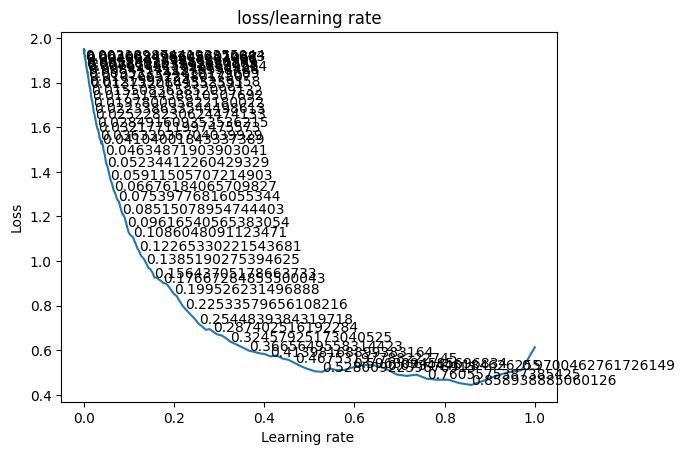

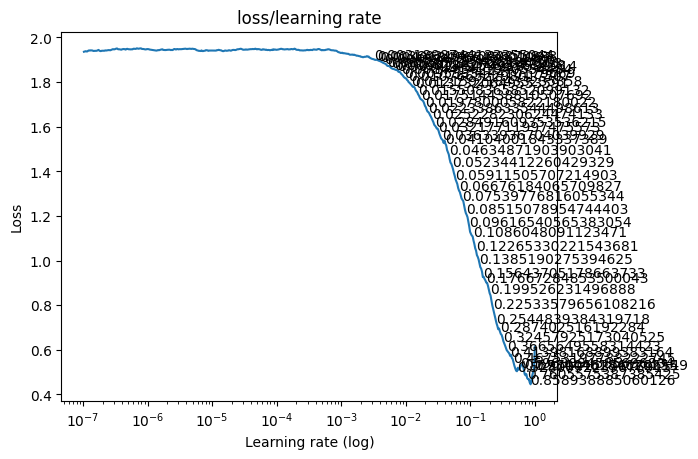

In [19]:
plot_learning_loss(lr_rates, losses, log_scale=False)
plot_learning_loss(lr_rates, losses, log_scale=True)

In [24]:
lr_rates, losses
print(np.min(lr_rates))
print(np.min(lr_rates)/10.0)

1.0308786545169485e-07
1.0308786545169486e-08


In [20]:
model = load_and_prep_resnet50()
optimizer = get_optimizer(model)
step_size = 4 * len(dataloader_train)
# "a good upper bound is not on the lowest point, but about a factor of 10 to the left."
upper = 0.08
# "A good lower bound, according to the paper and other sources, is the upper bound, divided by a factor 6."
lower = upper/6
# cycles the learning rate between two boundaries with a constant frequency. 
# changes the learning rate after every batch. step should be called after a batch has been used for training.
cycle_scheduler2 = lr_scheduler.CyclicLR(optimizer=optimizer,base_lr=lower, max_lr=upper, step_size_up=step_size)

In [26]:
base_model_cycle, base_data_cycle = train_model_scheduled(model=model, optimizer=optimizer, scheduler=cycle_scheduler2, num_epoch=60, train=dataloader_train_16, validation=dataloader_validation_16 )



Epoch 1/60
----------
Learning rate: 0.0134131
Train Loss: 1.0963 Acc: 0.6790
Val Loss: 0.4777 Acc: 0.9808
Epoch time 1m 37s
----------

Epoch 2/60
----------
Learning rate: 0.0176396
Train Loss: 0.3468 Acc: 0.9497
Val Loss: 0.2751 Acc: 0.9615
Epoch time 1m 41s
----------

Epoch 3/60
----------
Learning rate: 0.021866
Train Loss: 0.2257 Acc: 0.9725
Val Loss: 0.1841 Acc: 0.9712
Epoch time 1m 40s
----------

Epoch 4/60
----------
Learning rate: 0.0260925
Train Loss: 0.1727 Acc: 0.9832
Val Loss: 0.1814 Acc: 0.9519
Epoch time 1m 36s
----------

Epoch 5/60
----------
Learning rate: 0.030319
Train Loss: 0.1570 Acc: 0.9749
Val Loss: 0.1351 Acc: 0.9808
Epoch time 1m 35s
----------

Epoch 6/60
----------
Learning rate: 0.0345455
Train Loss: 0.1124 Acc: 0.9868
Val Loss: 0.1063 Acc: 0.9712
Epoch time 1m 35s
----------

Epoch 7/60
----------
Learning rate: 0.0387719
Train Loss: 0.0866 Acc: 0.9904
Val Loss: 0.1115 Acc: 0.9808
Epoch time 1m 35s
----------

Epoch 8/60
----------
Learning rate: 0.0429

In [ ]:
# unfreeze_layers(freezeTrained_model_cycle2)
# man skal vel også reload learning rate scheduler ?? Synes ikke de gør til tø tho...
# model_cycle2, model_cycle_data2 = train_model_scheduled(model=freezeTrained_model_cycle2, optimizer=optimizer, scheduler=cycle_scheduler2, num_epoch=24, train=dataloader_train, validation=dataloader_validation)

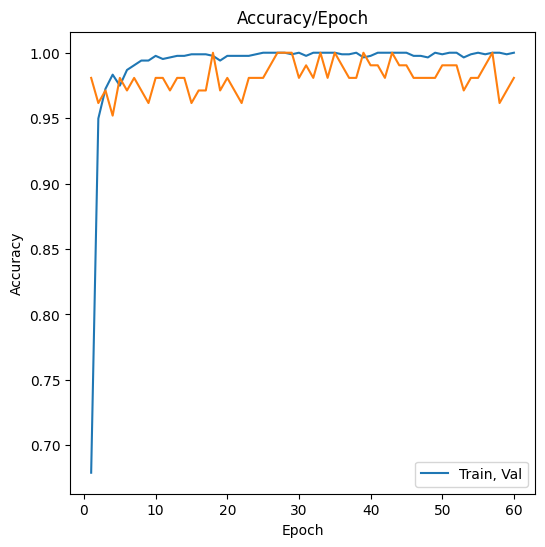

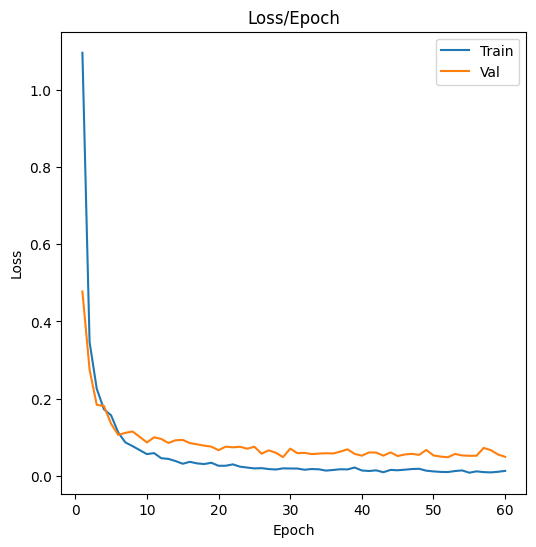

In [27]:
plot_accuracies(base_data_cycle["train_acc"], base_data_cycle["val_acc"], ["Train, Val"])
plot_loss(base_data_cycle["train_loss"], base_data_cycle["val_loss"])

[[15  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0]
 [ 0  0 15  0  0  0  0]
 [ 0  0  0 15  0  0  0]
 [ 0  0  2  0 13  0  0]
 [ 0  1  0  0  0 14  0]
 [ 0  0  0  0  0  0 15]]
Accuracy 97.14285714285714


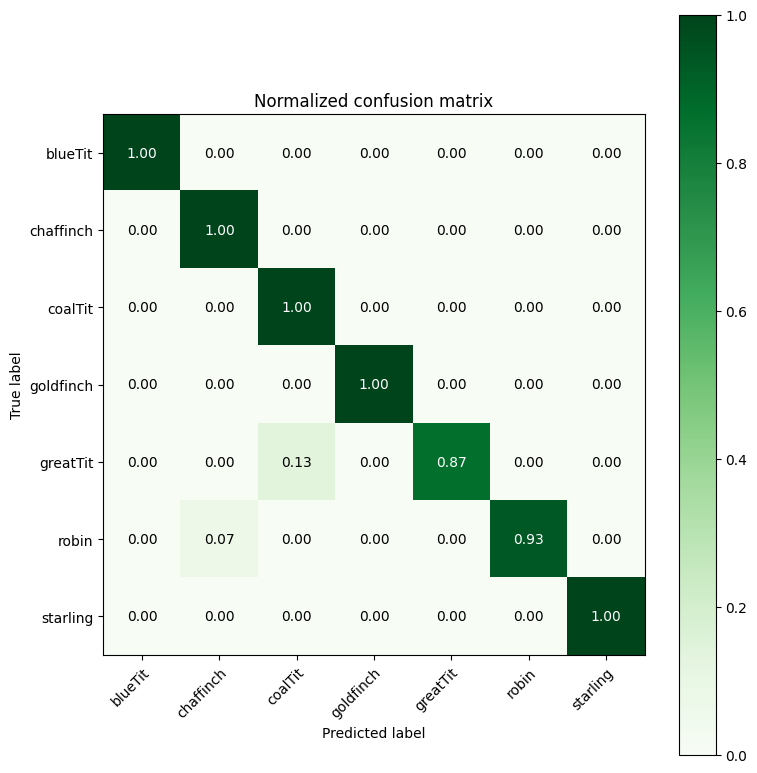

In [28]:
truel, predl = makeAll(dataloader_test_16, base_model_cycle, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
acc = np.sum(predl==truel)/predl.size * 100
print("Accuracy", acc)

[[ 266  264  228  219  395   56  650]
 [ 164 1047  244  785   46  277  989]
 [ 160  161  625  594  117   63  126]
 [   4   65  111 1765   13   26   16]
 [ 128  201  255  193  533   96  627]
 [   6   82   10   42   28  446  814]
 [  55  311  395  131   53  150 1047]]
Accuracy 37.99323562570463


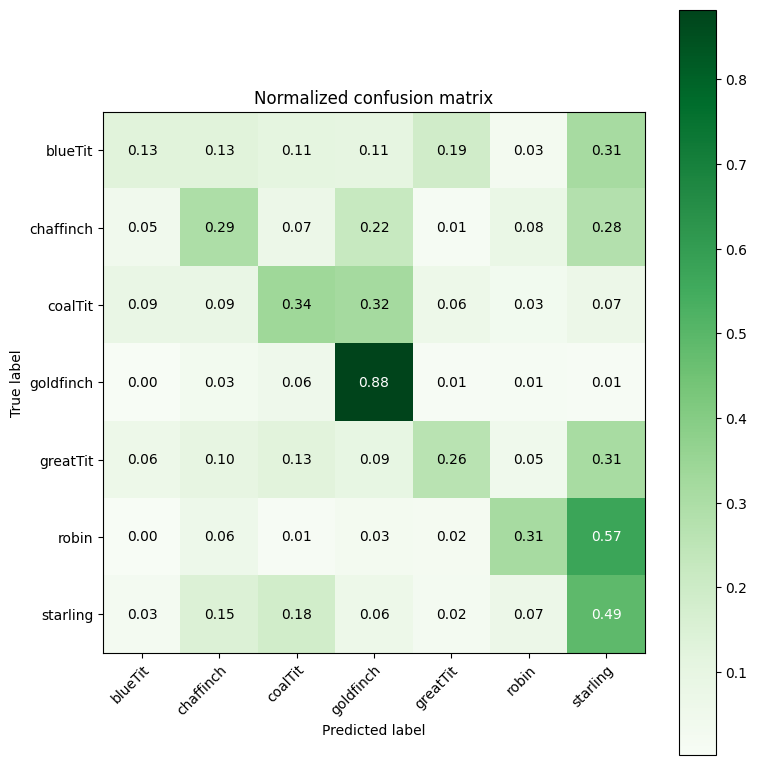

In [29]:
truel_feeder, predl_feeder = makeAll(dataloader_feeder_16, base_model_cycle, device)
plot_confusion_matrix(truel_feeder, predl_feeder, class_labels, normalize=True)
acc_feeder = np.sum(predl_feeder==truel_feeder)/predl_feeder.size * 100
print("Accuracy", (acc_feeder))

In [30]:
# torch.save({"model_cycle": model_cycle2.state_dict(), "model_cycle_data": model_cycle_data2 }, "Cycle2.tar")
torch.save({"model": base_model_cycle.state_dict(), "info": base_data_cycle, "epochs": 60, "batch_size": 16, "optimizer": "SGD", "acc": acc, "acc_feeder": acc_feeder }, "base_cycle.tar")

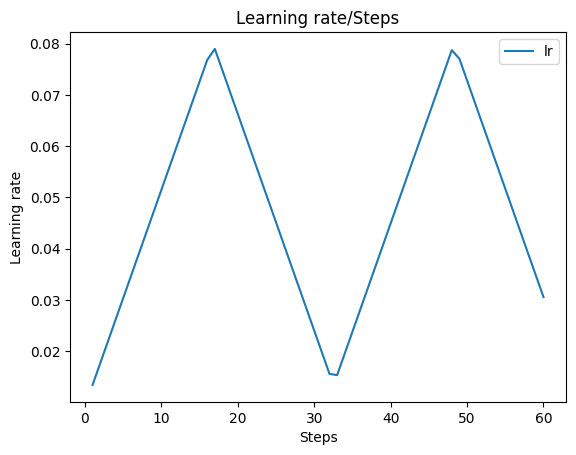

In [31]:
plot_learning_rate(base_data_cycle["lr_rates"])